# Classification on `emnist`

## 1. Create `Readme.md` to document your work

Explain your choices, process, and outcomes.

## 2. Classify all symbols

### Choose a model

Your choice of model! Choose wisely...

### Train away!

Is do you need to tune any parameters? Is the model expecting data in a different format?

### Evaluate the model

Evaluate the models on the test set, analyze the confusion matrix to see where the model performs well and where it struggles.

### Investigate subsets

On which classes does the model perform well? Poorly? Evaluate again, excluding easily confused symbols (such as 'O' and '0').

### Improve performance

Brainstorm for improving the performance. This could include trying different architectures, adding more layers, changing the loss function, or using data augmentation techniques.

## 2. Classify digits vs. letters model showdown

Perform a full showdown classifying digits vs letters:

1. Create a column for whether each row is a digit or a letter
2. Choose an evaluation metric 
3. Choose several candidate models to train
4. Divide data to reserve a validation set that will NOT be used in training/testing
5. K-fold train/test
    1. Create train/test splits from the non-validation dataset 
    2. Train each candidate model (best practice: use the same split for all models)
    3. Apply the model the the test split 
    4. (*Optional*) Perform hyper-parametric search
    5. Record the model evaluation metrics
    6. Repeat with a new train/test split
6. Promote winner, apply model to validation set
7. (*Optional*) Perform hyper-parametric search, if applicable
8. Report model performance

In [17]:
# Install required packages (once per virtual environment)
%pip install -q numpy pandas matplotlib seaborn scikit-learn tensorflow[and-cuda] xgboost
%reset -f

Note: you may need to restart the kernel to use updated packages.


In [18]:
# Import packages
import os
import string
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
import emnist
from IPython.display import display, Markdown


# ML packages
# Random Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import cross_val_score, KFold, ParameterGrid, train_test_split
# Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
# XGBoost (SVM)
from xgboost import XGBClassifier
# Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
import numpy as np
# Constants
SIZE = 28
REBUILD = True
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # or 3 to suppress all warnings


In [19]:
# Define helper functions
def int_to_char(label):
    """Convert an integer label to the corresponding uppercase character."""
    if label < 10:
        return str(label)
    elif label < 36:
        return chr(label - 10 + ord('A'))
    else:
        return chr(label - 36 + ord('a'))

def show_image(row):
    """Display a single image and its corresponding label."""
    image = row['image']
    label = row['label']
    plt.imshow(image, cmap='gray')
    plt.title('Label: ' + int_to_char(label))
    plt.axis('off')
    plt.show()

def show_grid(data, title=None, num_cols=5, figsize=(20, 10)):
    """
    Display a list of images as a grid of num_cols columns.
    images: a list of images, each represented as a 28x28 numpy array
    labels: a list of labels, one for each image
    title: (optional) a title for the plot
    num_cols: (optional) number of columns to use in the grid
    figsize: (optional) size of the figure
    """
    num_images = len(data)
    num_rows = (num_images - 1) // num_cols + 1
    fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    if title is not None:
        fig.suptitle(title, fontsize=16)
    for i in range(num_rows):
        for j in range(num_cols):
            index = i * num_cols + j
            if index < num_images:
                axes[i, j].imshow(data.iloc[index]['image'], cmap='gray')
                axes[i, j].axis('off')
                label = int_to_char(data.iloc[index]['label'])
                axes[i, j].set_title(label)
    plt.show()

# Get a random image of a given label from the dataset
def get_image_by_label(data, label):
    """Get a random image of a given label from the dataset."""
    images = data[data['label'] == label]['image'].tolist()
    return random.choice(images)

# Plot the training and validation accuracy during the training of a model
def plot_accuracy(history):
    """Plot the training and validation accuracy during the training of a model."""
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    epochs = range(1, len(acc) + 1)
    plt.plot(epochs, acc, 'bo', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

# Plot the training and validation loss during the training of a model
def plot_loss(history):
    """Plot the training and validation loss during the training of a model."""
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(loss) + 1)
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Normalize the pixel values of the images in the dataset to have zero mean and unit variance
# This is a common preprocessing step for neural networks, but may not be necessary in all cases
def normalize_images(images):
    """Normalize the pixel values of the images in the dataset to have zero mean and unit variance."""
    images = np.array(images)
    mean = images.mean()
    std = images.std()
    images = (images - mean) / std
    return images.tolist()


# Display metrics for a model
def display_metrics(task, model_name, metrics_dict):
    """Display performance metrics and confusion matrix for a model."""
    metrics_df = pd.DataFrame()
    cm_df = pd.DataFrame()
    for key, value in metrics_dict[task][model_name].items():
        if type(value) == np.ndarray:
            cm_df = pd.DataFrame(value, index=[''], columns=[''])
        else:
            metrics_df[key] = [value]
    display(Markdown(f'# Performance Metrics: {model_name}'))
    display(metrics_df)
    display(Markdown(f'# Confusion Matrix: {model_name}'))
    display(cm_df)



# assign metrics from model to a dictionary
def dict_assignment(metrics_dict, *keys):
    current_dict = metrics_dict
    for key in keys:
        if key not in current_dict:
            raise KeyError(f"Key '{key}' not found in the dictionary")
        current_dict = current_dict[key]
    for metric, value in current_dict.items():
        if isinstance(value, np.ndarray):
            print(f"metrics_dict{''.join([f'[{repr(k)}]' for k in keys])}['{metric}'] = np.array({value.tolist()})")
        else:
            print(f"metrics_dict{''.join([f'[{repr(k)}]' for k in keys])}['{metric}'] = {value}")

In [20]:
# Load data

# Extract the training split as images and labels
image, label = emnist.extract_training_samples('byclass')

# Add columns for each pixel value (28x28 = 784 columns)
train = pd.DataFrame()

# Add a column with the image data as a 28x28 array
train['image'] = list(image)
train['image_flat'] = train['image'].apply(lambda x: np.array(x).reshape(-1))

# Add a column showing the label
train['label'] = label

# Convert labels to characters
class_label = np.array([int_to_char(l) for l in label])

# Add a column with the character corresponding to the label
train['class'] = class_label

# Repeat for the test split
image, label = emnist.extract_test_samples('byclass')
class_label = np.array([int_to_char(l) for l in label])
valid = pd.DataFrame()
valid['image'] = list(image)
valid['image_flat'] = valid['image'].apply(lambda x: np.array(x).reshape(-1))
valid['label'] = label
valid['class'] = class_label

In [21]:
train['image_flat']

0         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
1         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
2         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
3         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
4         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
                                ...                        
697927    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
697928    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
697929    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
697930    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
697931    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
Name: image_flat, Length: 697932, dtype: object

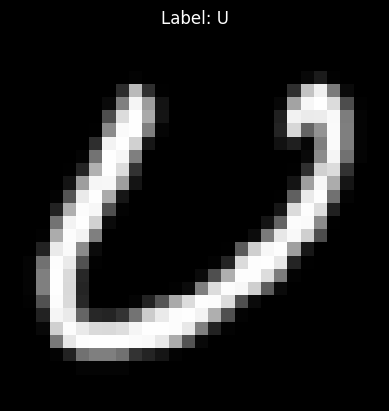

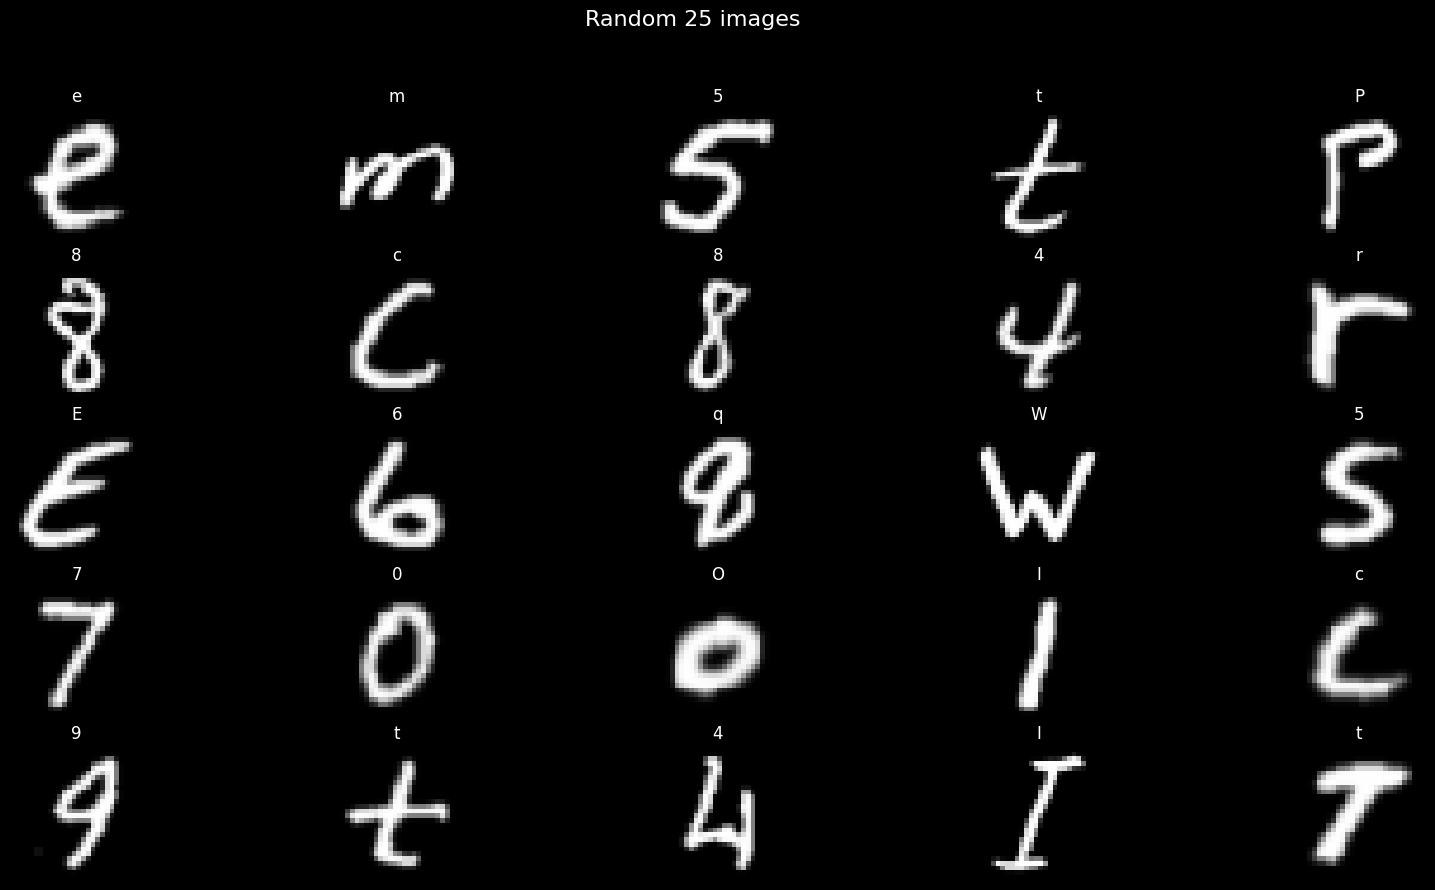

In [22]:
# Using the helper functions

# Plot a random image from the training set
index = np.random.randint(0, len(train))
show_image(train.iloc[index])

# Show a random set of 25 images in a 5x5 grid
show_grid(train.sample(25), title='Random 25 images')

# Show the first 25 images in a 5x5 grid
# show_grid(train[:25], title='First 25 images')

# Isn't it nice to have a helper function to do this for you?


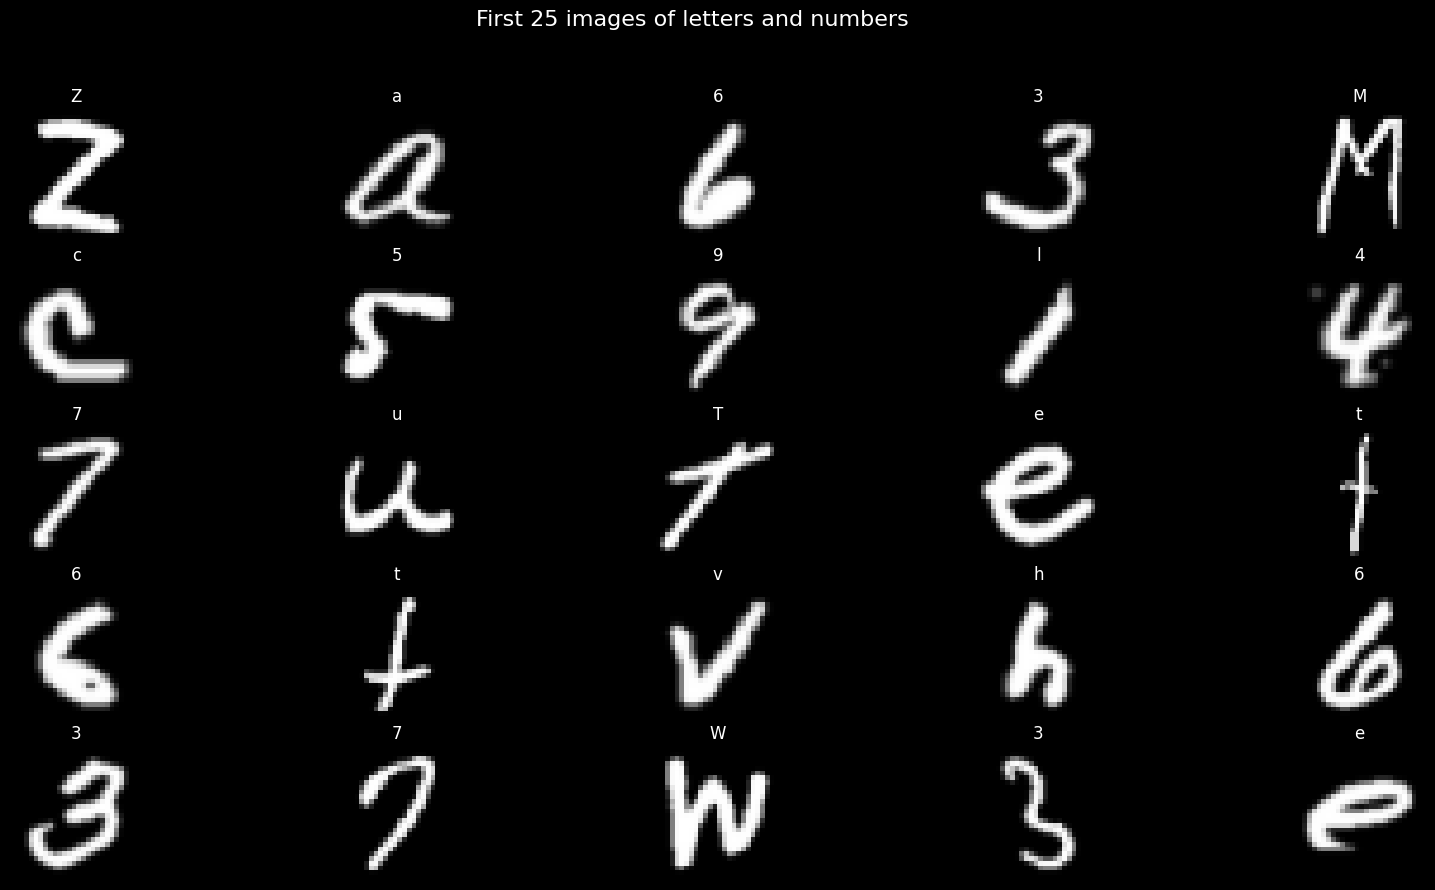

In [23]:
# alphanumeric classifier

# Subset `train` and `valid`
symbols_list = [str(i) for i in range(10)] + [chr(ord('A') + i) for i in range(26)] + [chr(ord('a') + i) for i in range(26)]

mask_train = train['class'].apply(lambda x: x in symbols_list)
train_01 = train[mask_train]
train_01.reset_index(drop=True, inplace=True)

mask_valid = valid['class'].apply(lambda x: x in symbols_list)
valid_01 = valid[mask_valid]
valid_01.reset_index(drop=True, inplace=True)



# Create a dictionary for performance metrics
metrics_dict = {}




show_grid(train_01[:25], title="First 25 images of letters and numbers")


In [24]:
# (OPTIONAL) We can define all the metrics we want to track in a dictionary
metrics_dict = {
    'AlphaNumeric' : { # task name alphanumeric classifier.
        'logistic_regression': {
            'confusion_matrix': [],
            'accuracy': [],
            'precision': [],
            'recall': [],
            'f1': []
        },
        'xgboost': {
            'confusion_matrix': [],
            'accuracy': [],
            'precision': [],
            'recall': [],
            'f1': []
        },
        'random_forest': {
            'confusion_matrix': [],
            'accuracy': [],
            'precision': [],
            'recall': [],
            'f1': []
        },
        'neural_network': {
            'confusion_matrix': [],
            'accuracy': [],
            'precision': [],
            'recall': [],
            'f1': []
        }
    }
}

### Neural Network


Epoch 1/5
21811/21811 [==============================] - 36s 2ms/step - loss: 0.6289 - accuracy: 0.7981 - val_loss: 0.5196 - val_accuracy: 0.8248
Epoch 2/5
21811/21811 [==============================] - 36s 2ms/step - loss: 0.4978 - accuracy: 0.8295 - val_loss: 0.4993 - val_accuracy: 0.8268
Epoch 3/5
21811/21811 [==============================] - 36s 2ms/step - loss: 0.4760 - accuracy: 0.8356 - val_loss: 0.4936 - val_accuracy: 0.8342
Epoch 4/5
21811/21811 [==============================] - 37s 2ms/step - loss: 0.4643 - accuracy: 0.8390 - val_loss: 0.5047 - val_accuracy: 0.8295
Epoch 5/5
3636/3636 [==============================] - 2s 648us/step


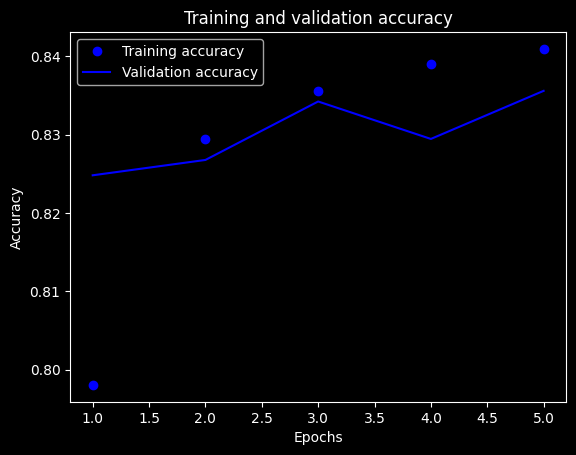

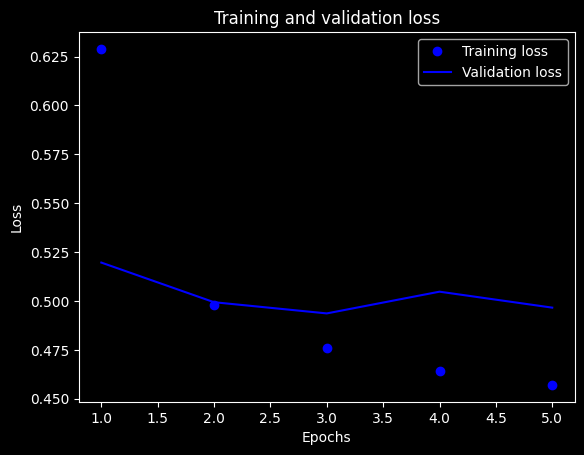

In [25]:
# Alphanumeric Classifier: Neural Network
task = 'AlphaNumeric'
model_name = 'neural_network'

# Set random seed for reproducibility
tf.random.set_seed(42)

# Convert data to tensor
train_images = np.array(train_01['image'])
train_images = np.array(list(map(lambda x: np.reshape(x, (28, 28, 1)), train_images)))
train_images = train_images / 255.0
train_labels = np.array(train_01['label'])
valid_images = np.array(valid_01['image'])
valid_images = np.array(list(map(lambda x: np.reshape(x, (28, 28, 1)), valid_images)))
valid_images = valid_images / 255.0
valid_labels = np.array(valid_01['label'])

# Initialize neural network model
model = Sequential([
    keras.layers.InputLayer(input_shape=(28, 28, 1)),
    keras.layers.Flatten(),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dense(62, activation='softmax')
])

# Compile the model, specifying the optimizer, loss function, and metrics 
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model, saving the history of the training process
history = model.fit(train_images, train_labels, epochs=5, validation_data=(valid_images, valid_labels))

# Evaluate the model
loss, acc = model.evaluate(valid_images, valid_labels)
predictions = model.predict(valid_images)
y_pred = np.argmax(predictions, axis=1)

# Calculate performance metrics
prec = precision_score(valid_labels, y_pred, average='macro')
rec = recall_score(valid_labels, y_pred, average='macro')
f1 = f1_score(valid_labels, y_pred, average='macro')
cm = multilabel_confusion_matrix(valid_labels, y_pred)

# Store performance metrics in dictionary
metrics_dict[task][model_name] = {'accuracy': acc,
                                  'precision': prec,
                                  'recall': rec,
                                  'f1': f1,
                                  'confusion_matrix': cm}

# Display performance metrics
# display_metrics(task, model_name, metrics_dict)

# Plot the training and validation accuracy during the training of the model
plot_accuracy(history)
plot_loss(history)

In [26]:
# Show the performance metrics for all models as a raw dictionary

if not REBUILD:
    metrics_dict['AlphaNumeric']['neural_network'] = {
                                          'accuracy': 0.9995870590209961,
                                         'precision': 0.9992107340173638,
                                            'recall': 1.0,
                                                'f1': 0.9996052112120015,
                                  'confusion_matrix': [[5773,    5],
                                                       [   0, 6330]]
                                          }

display(metrics_dict)

confusion_alphanumeric = list(zip(symbols_list, cm))

{'AlphaNumeric': {'logistic_regression': {'confusion_matrix': [],
   'accuracy': [],
   'precision': [],
   'recall': [],
   'f1': []},
  'xgboost': {'confusion_matrix': [],
   'accuracy': [],
   'precision': [],
   'recall': [],
   'f1': []},
  'random_forest': {'confusion_matrix': [],
   'accuracy': [],
   'precision': [],
   'recall': [],
   'f1': []},
  'neural_network': {'accuracy': 0.8355957269668579,
   'precision': 0.7209755868605775,
   'recall': 0.6949887253220511,
   'f1': 0.696879949845161,
   'confusion_matrix': array([[[108189,   2356],
           [  1067,   4711]],
   
          [[107214,   2779],
           [   581,   5749]],
   
          [[110137,    317],
           [   334,   5535]],
   
          [[110130,    224],
           [   112,   5857]],
   
          [[110256,    448],
           [   220,   5399]],
   
          [[110479,    654],
           [   353,   4837]],
   
          [[110338,    280],
           [   200,   5505]],
   
          [[110031,    153],
  

### Plot the confusion matrices to assess classification performance.
*Poor performers will be removed prior to regenerating the model.*


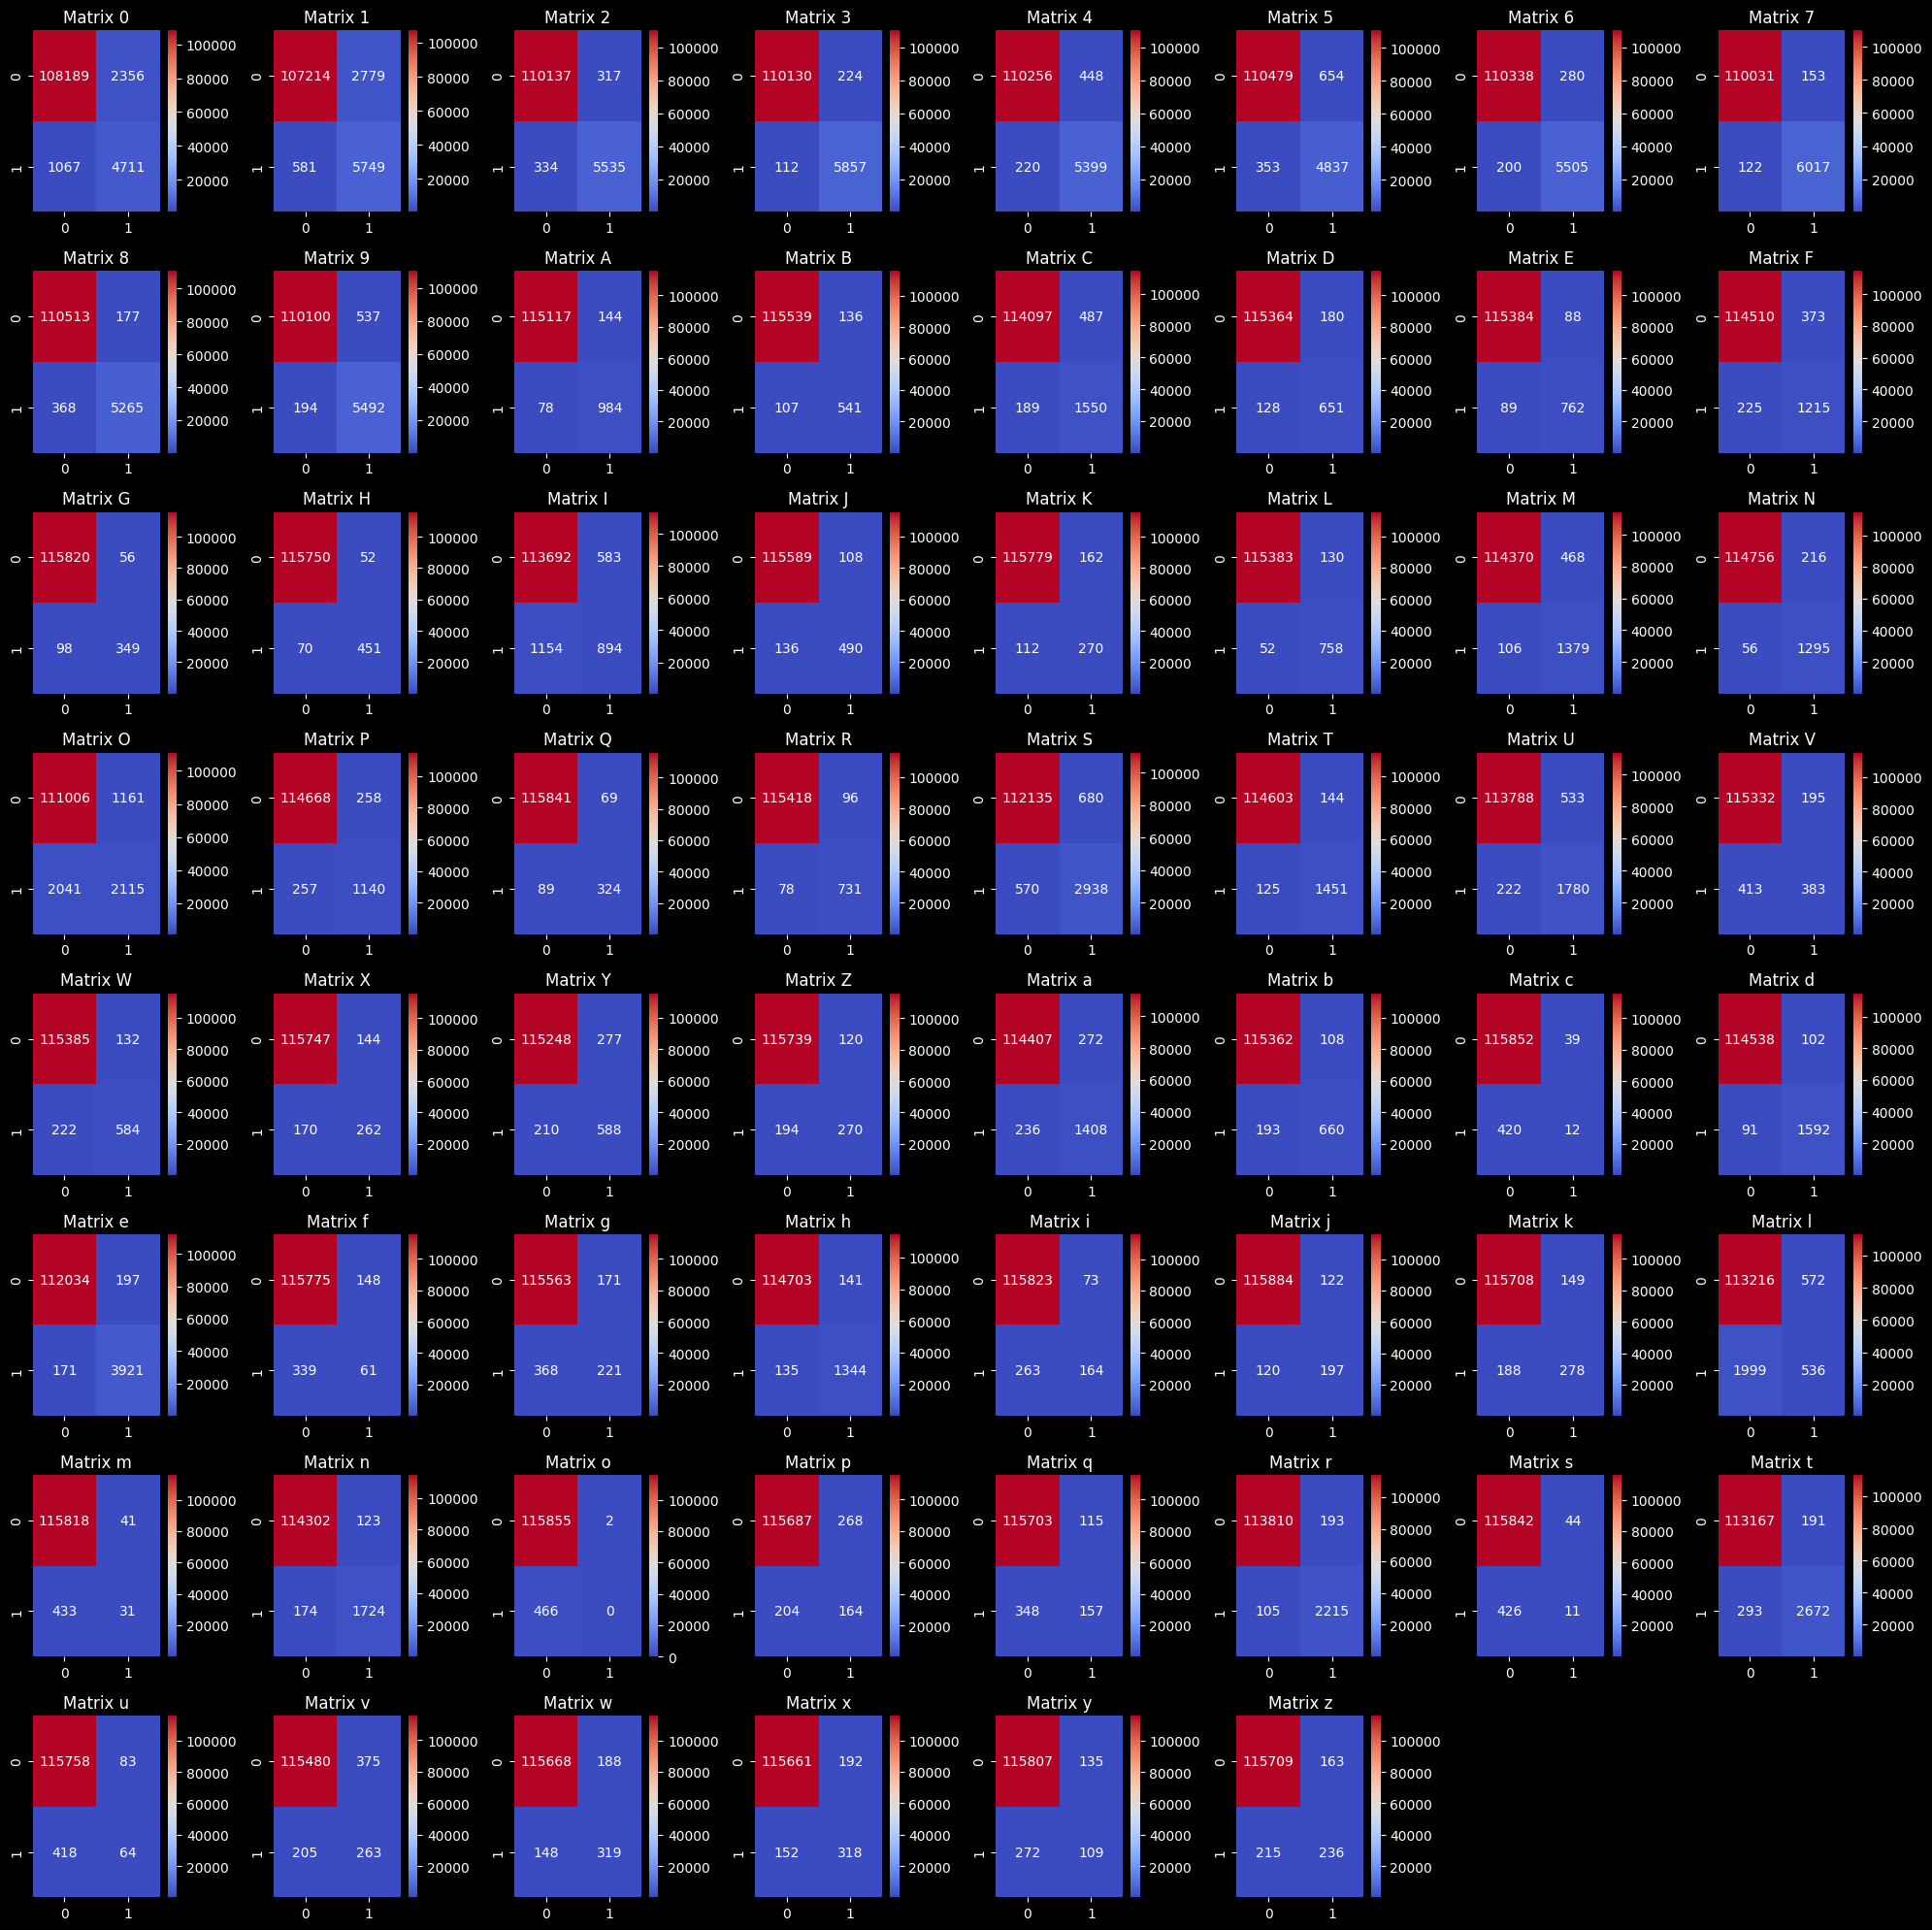

In [27]:


# Setting up the plot
fig, axes = plt.subplots(nrows=8, ncols=8, figsize=(20, 20))

# Flatten the axes array for easy indexing
axes = axes.flatten()

for i, (symbol, matrix) in enumerate(confusion_alphanumeric):
    # Using seaborn to create a heatmap for each confusion matrix
    sns.heatmap(matrix, annot=True, fmt="g", cmap="coolwarm", ax=axes[i])
    # Adding the alphanumeric index as the title of each subplot
    axes[i].set_title(f"Matrix {symbol}")

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

In [28]:
# create an empty DataFrame to hold the results
results_df = pd.DataFrame()

# iterate over the keys in the metrics_dict
for key in metrics_dict:
    
    # create a new DataFrame to hold the results for this key
    df = pd.DataFrame.from_dict(metrics_dict[key], orient='index')
    
    # add a new row to the DataFrame indicating the model name and metric type
    df = df.assign(model=key, metric=df.index)
    
    # set the index to the 'model' and 'metric' columns
    df = df.set_index(['model', 'metric'])
    
    # append the results to the main DataFrame
    results_df = pd.concat([results_df, df])

# display the resulting table
display(results_df)


confusion_matrix  \
model        metric                                                                   
AlphaNumeric logistic_regression                                                 []   
             xgboost                                                             []   
             random_forest                                                       []   
             neural_network       [[[108189, 2356], [1067, 4711]], [[107214, 277...   

                                  accuracy precision    recall       f1  
model        metric                                                      
AlphaNumeric logistic_regression        []        []        []       []  
             xgboost                    []        []        []       []  
             random_forest              []        []        []       []  
             neural_network       0.835596  0.720976  0.694989  0.69688

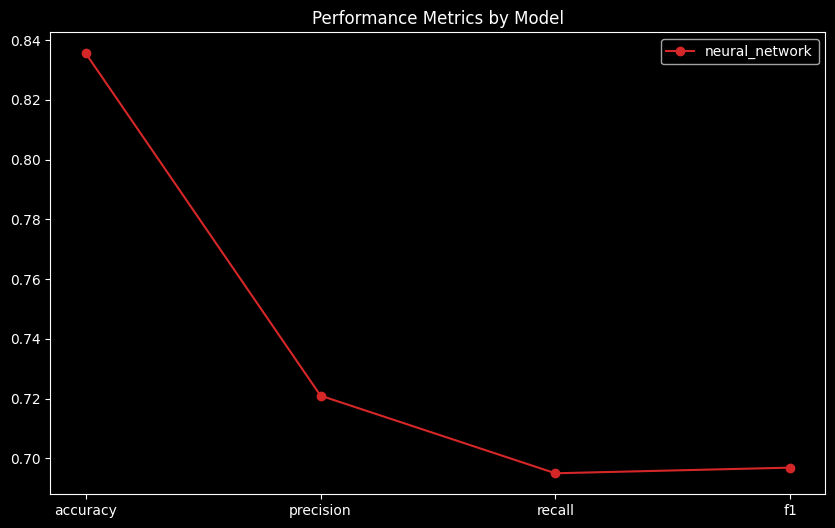

In [29]:
# adapted from sample code.  only one model used so one color is used
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

# create a new figure
fig, ax = plt.subplots(figsize=(10, 6))

# set the x-axis labels
labels = ['accuracy', 'precision', 'recall', 'f1']

# iterate over the models in the metrics_dict
for i, model in enumerate(metrics_dict['AlphaNumeric'].keys()):
    # extract the metric values for this model
    values = [metrics_dict['AlphaNumeric'][model][label] for label in labels]
    
    # plot the values as a line
    ax.plot(labels, values, label=model, marker='o', color=colors[i])

    
# add a legend and title
ax.legend()
ax.set_title('Performance Metrics by Model')

# show the plot
plt.show()


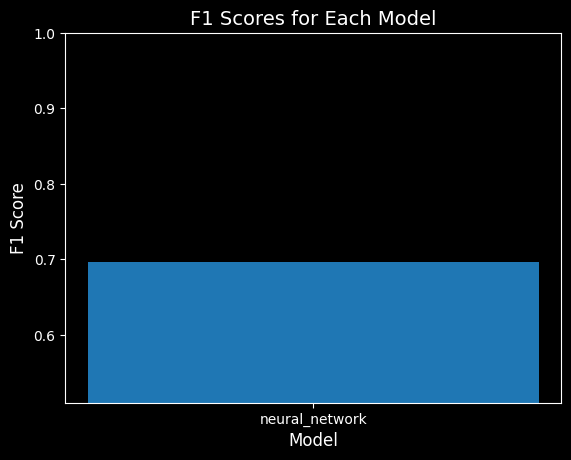

In [30]:
models = ['neural_network']
accuracies = [metrics_dict['AlphaNumeric'][model]['f1'] for model in models]

plt.bar(models, accuracies, color=colors)
plt.title('F1 Scores for Each Model', fontsize=14)
plt.xlabel('Model', fontsize=12)
plt.ylabel('F1 Score', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.ylim([0.51, 1.0])
plt.show()

Based on the initial model and accompanying confusion matrices, we see that several classes have high numbers of FP and FN relative to TP and TN.  The classes were not balanced but based on the false classifications it seems warranted to remove zeros, ones, twos, uppercase o, uppercase i, and uppercase z to address ambiguous classes.

> ##### Removed
>
> *Numeric*
> - 0,1,2
>
> *Letters*
> - O,I,Z

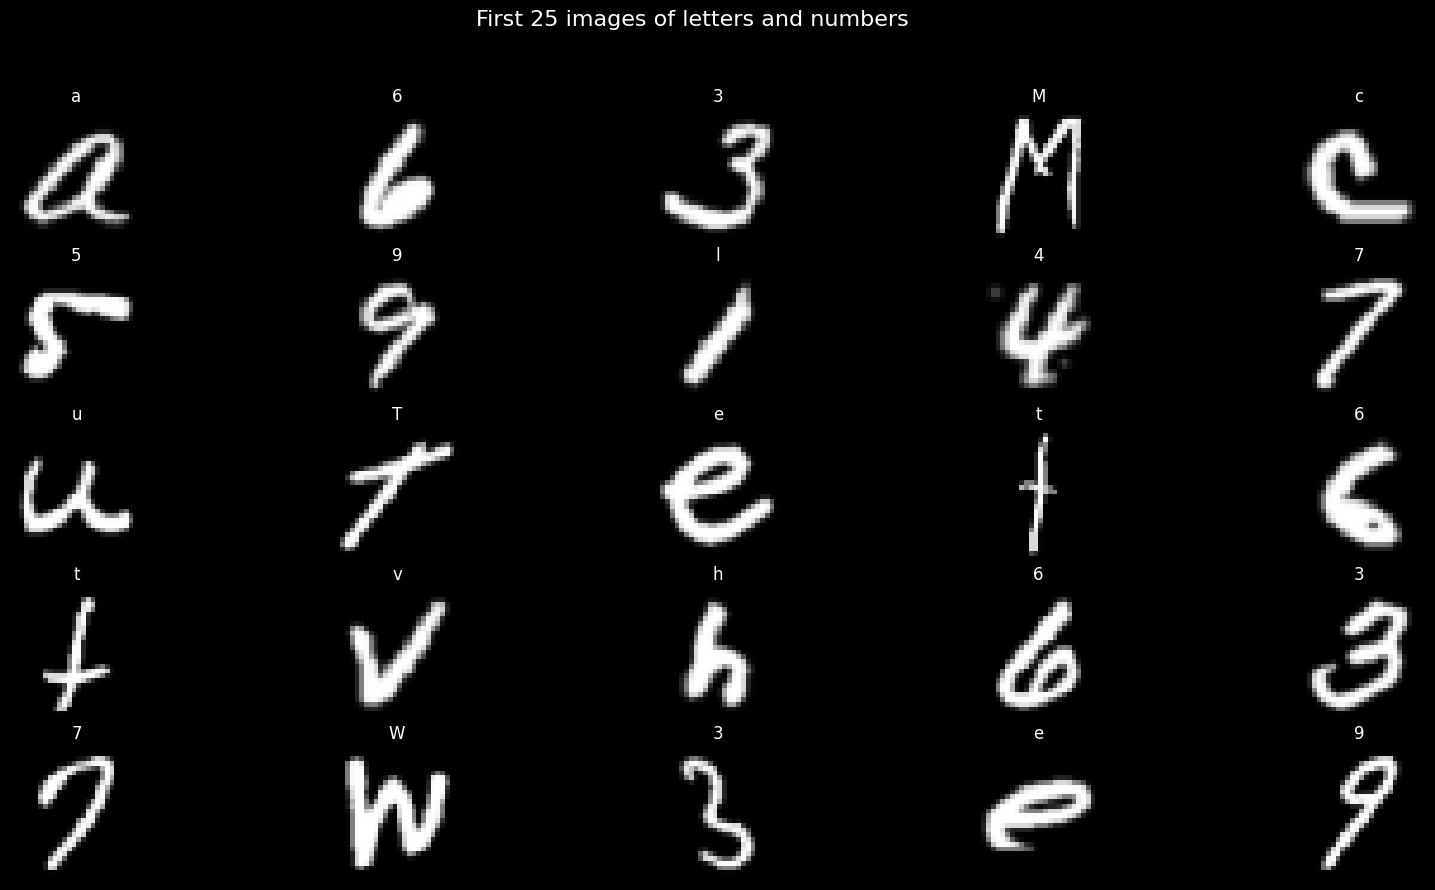

In [31]:
# alphanumeric classifier

# Subset `train` and `valid`
symbols_list = [str(i) for i in range(10)] + [chr(ord('A') + i) for i in range(26)] + [chr(ord('a') + i) for i in range(26)]
remove_ambiguous = ['0','1','O','I','2','Z']
filtered_symbols_list = [symbol for symbol in symbols_list if symbol not in remove_ambiguous]


mask_train_new = train['class'].apply(lambda x: x in filtered_symbols_list)
train_02 = train[mask_train_new]
train_02.reset_index(drop=True, inplace=True)

mask_valid_new = valid['class'].apply(lambda x: x in filtered_symbols_list)
valid_02 = valid[mask_valid_new]
valid_02.reset_index(drop=True, inplace=True)



# Create a dictionary for performance metrics

#metrics_dict_2['AlphaNumeric'] = {}
#metrics_dict_2['AlphaNumeric']['neural_network'] = {}



show_grid(train_02[:25], title="First 25 images of letters and numbers")


Epoch 1/5
17224/17224 [==============================] - 26s 1ms/step - loss: 0.6090 - accuracy: 0.8232 - val_loss: 0.4459 - val_accuracy: 0.8631
Epoch 2/5
17224/17224 [==============================] - 25s 1ms/step - loss: 0.4296 - accuracy: 0.8660 - val_loss: 0.4095 - val_accuracy: 0.8732
Epoch 3/5
17224/17224 [==============================] - 25s 1ms/step - loss: 0.4001 - accuracy: 0.8738 - val_loss: 0.4093 - val_accuracy: 0.8709
Epoch 4/5
17224/17224 [==============================] - 25s 1ms/step - loss: 0.3854 - accuracy: 0.8774 - val_loss: 0.3983 - val_accuracy: 0.8746
Epoch 5/5
2865/2865 [==============================] - 2s 596us/step


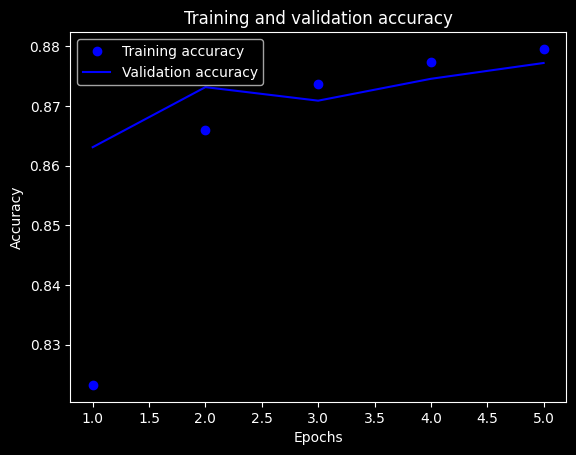

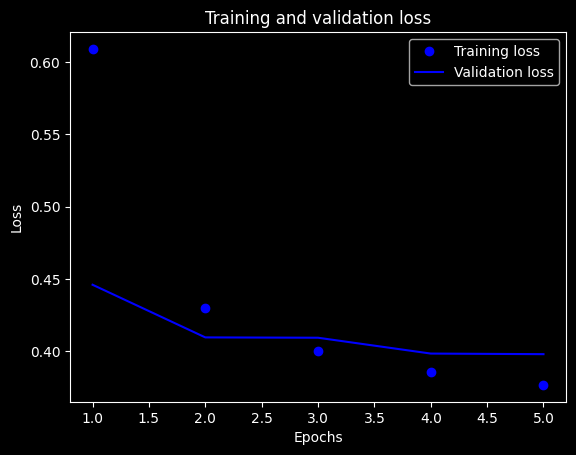

In [32]:
# Alphanumeric Classifier: Neural Network
task = 'AlphaNumeric'
model_name = 'neural_network'

# Set random seed for reproducibility
tf.random.set_seed(42)

# Convert data to tensor
train_images_new = np.array(train_02['image'])
train_images_new = np.array(list(map(lambda x: np.reshape(x, (28, 28, 1)), train_images_new)))
train_images_new = train_images_new / 255.0
train_labels_new = np.array(train_02['label'])
valid_images_new = np.array(valid_02['image'])
valid_images_new = np.array(list(map(lambda x: np.reshape(x, (28, 28, 1)), valid_images_new)))
valid_images_new = valid_images_new / 255.0
valid_labels_new = np.array(valid_02['label'])

# Initialize neural network model
model_2 = Sequential([
    keras.layers.InputLayer(input_shape=(28, 28, 1)),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(62, activation='softmax')
])

# Compile the model, specifying the optimizer, loss function, and metrics 
model_2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model, saving the history of the training process
history_new = model_2.fit(train_images_new, train_labels_new, epochs=5, validation_data=(valid_images_new, valid_labels_new))

# Evaluate the model
loss, acc = model_2.evaluate(valid_images_new, valid_labels_new)
predictions = model_2.predict(valid_images_new)
y_pred = np.argmax(predictions, axis=1)

# Calculate performance metrics
prec = precision_score(valid_labels_new, y_pred, average='macro')
rec = recall_score(valid_labels_new, y_pred, average='macro')
f1 = f1_score(valid_labels_new, y_pred, average='macro')
cm = multilabel_confusion_matrix(valid_labels_new, y_pred)

# Store performance metrics in dictionary
metrics_dict[task][model_name] = {'accuracy': acc,
                                  'precision': prec,
                                  'recall': rec,
                                  'f1': f1,
                                  'confusion_matrix': cm}

# Display performance metrics
# display_metrics(task, model_name, metrics_dict)

# Plot the training and validation accuracy during the training of the model
plot_accuracy(history_new)
plot_loss(history_new)

In [33]:
# Show the performance metrics for all models as a raw dictionary

if not REBUILD:
    metrics_dict['AlphaNumeric']['neural_network'] = {
                                          'accuracy': 0.9995870590209961,
                                         'precision': 0.9992107340173638,
                                            'recall': 1.0,
                                                'f1': 0.9996052112120015,
                                  'confusion_matrix': [[5773,    5],
                                                       [   0, 6330]]
                                          }

display(metrics_dict)

confusion_alphanumeric = list(zip(symbols_list, cm))

{'AlphaNumeric': {'logistic_regression': {'confusion_matrix': [],
   'accuracy': [],
   'precision': [],
   'recall': [],
   'f1': []},
  'xgboost': {'confusion_matrix': [],
   'accuracy': [],
   'precision': [],
   'recall': [],
   'f1': []},
  'random_forest': {'confusion_matrix': [],
   'accuracy': [],
   'precision': [],
   'recall': [],
   'f1': []},
  'neural_network': {'accuracy': 0.8772115707397461,
   'precision': 0.7651728704245431,
   'recall': 0.7291146422609867,
   'f1': 0.7355715574116461,
   'confusion_matrix': array([[[85536,   173],
           [  150,  5819]],
   
          [[85701,   358],
           [  247,  5372]],
   
          [[86135,   353],
           [  603,  4587]],
   
          [[85566,   407],
           [  134,  5571]],
   
          [[85346,   193],
           [   85,  6054]],
   
          [[85730,   315],
           [  238,  5395]],
   
          [[85370,   622],
           [  158,  5528]],
   
          [[90440,   176],
           [   62,  1000]],
   

## 2. Classify digits vs. letters model showdown

Perform a full showdown classifying digits vs letters:

1. Create a column for whether each row is a digit or a letter
2. Choose an evaluation metric 
3. Choose several candidate models to train
4. Divide data to reserve a validation set that will NOT be used in training/testing
5. K-fold train/test
    1. Create train/test splits from the non-validation dataset 
    2. Train each candidate model (best practice: use the same split for all models)
    3. Apply the model the the test split 
    4. (*Optional*) Perform hyper-parametric search
    5. Record the model evaluation metrics
    6. Repeat with a new train/test split
6. Promote winner, apply model to validation set
7. (*Optional*) Perform hyper-parametric search, if applicable
8. Report model performance

In [34]:
# from the training and validation sets.
valid['class_type'] = valid['label'].apply(lambda x: 'numbers' if x in range(10) else 'letters')
# subset the data to work on a manageable data size.
valid_subset = valid.sample(frac=0.5)

# Data splitting for 
X=valid_subset['image_flat'].tolist()
y=valid_subset['class_type'].tolist()

# encode labels
le = LabelEncoder()
y=le.fit_transform(y)

In [35]:
# create the split datasets

# 1. Select candidate models, hyperparameter options, and evaluation metric
rf_param_grid = {'n_estimators': [50, 100, 150], 'max_depth': [None, 10, 20]}
xgb_param_grid = {'n_estimators': [50, 100, 150], 'max_depth': [3, 5, 7], 'learning_rate': [0.01, 0.1, 0.2]}

scoring_metric = 'accuracy'

# Split data into train and test
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Define how many folds you want to split on
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# What models?
models = [
    (RandomForestClassifier(), rf_param_grid),
    (XGBClassifier(), xgb_param_grid)
]

# Initialize best score and best model
best_score = 0
best_model = None


# Using sklearn's function.
for model, param_grid in models:
    for param_combination in ParameterGrid(param_grid):
        model.set_params(**param_combination)
 # cross_val_score returns array of scores, which you need to take the avg
        scores = cross_val_score(model, X_train, y_train, cv=kf, scoring='accuracy', n_jobs=-1)
        avg_score = np.mean(scores)
        if avg_score > best_score:
            best_score = avg_score
            best_model = model 

# Print the best model
print("Best Model:", best_model)
best_model_classifier = best_model.__class__
best_model_params = best_model.get_params()

Best Model: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=150, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)


In [36]:
best_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=150, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [37]:
y_val_pred = best_model.predict(X_val)
validation_score = accuracy_score(y_val, y_val_pred)
print(f"Validation Hold-out Score: {validation_score}")

Validation Hold-out Score: 0.8673600962778303
